# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [2]:
# Import necessary libraries
# =====================================================================

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import libraries for data preprocessing
import numpy as np
import pandas as pd
from tqdm.auto import trange, tqdm  # progress bar

# Import libraries for data and folder manipulation
import random
import os
import json

# Import libraries from tensorflow for building the model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers

# Import necessary libraries
# =====================================================================
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.data.create_dataset import *
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize

# from src.model.diffusion_model import *
from src.model.overfitting_test import *

In [3]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-19 19:29:45.749541: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 19:29:45.753430: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 19:29:45.753545: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 64
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 32
EPOCHS = 100
T = 1000
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

2024-04-19 19:29:47.320460: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 19:29:47.320614: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 19:29:47.320679: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
# load df and data_dict
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

with open(f"{DATA_PATH}/interim/pokemon_dict_dataset.json", "r") as f:
    data_dict = json.load(f)

from src.data.path_loader import PathLoader as pl

loader = pl(
    load_pattern=f"{DATA_PATH}/raw/sprites/**/front/**/*.png",
)

# Load the paths from the file
image_paths = loader.load_paths()

from src.data.create_dataset import dataset_dict

data_dict = dataset_dict(image_paths=image_paths, df=df)

Loading paths...

- Number of paths loaded: 8143



- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


2024-04-19 19:29:51.761020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


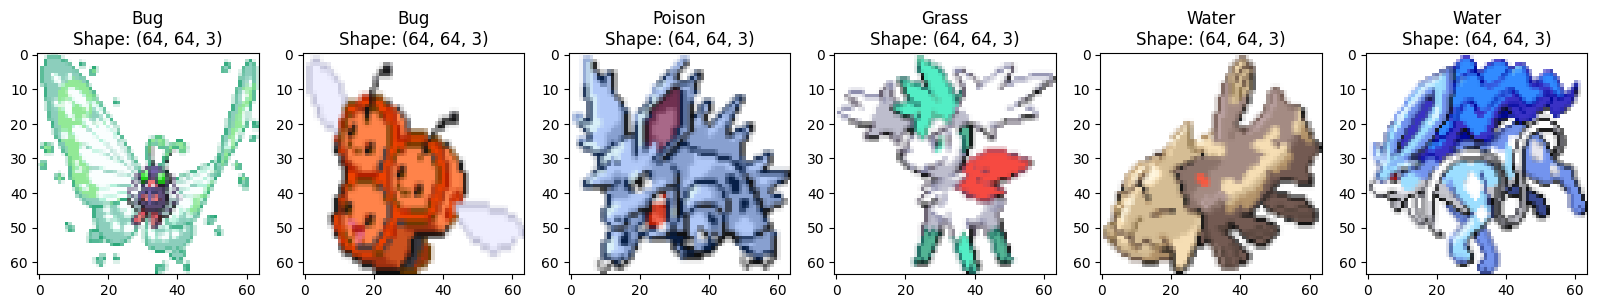

2024-04-19 19:29:52.290153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
# dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    df=df,
    dict_dataset=data_dict,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 64, 64, 3)
(32, 18)


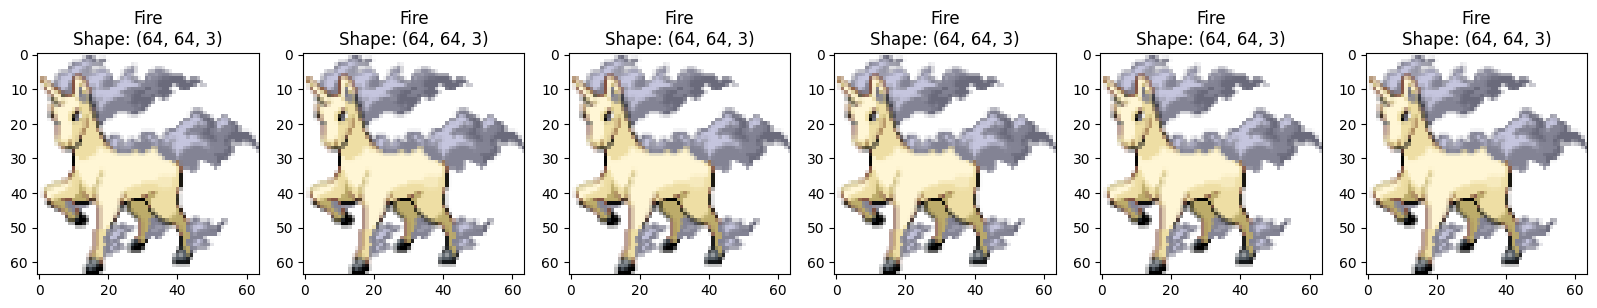

2024-04-19 19:40:28.203294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-19 19:40:28.204425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
# get one batch of the dataset
dataset_example = poke_dataset.take(1)

# get one specific image of the batch
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

# get only one image of the dataset
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

img_example = np.expand_dims(img_example, axis=0)  # expand the image to the batch size
label_example = np.expand_dims(
    label_example, axis=0
)  # expand the label to the batch size

dataset_example = tf.data.Dataset.from_tensor_slices((img_example, label_example))

dataset_example = dataset_example.repeat(1024).batch(BATCH_SIZE)

for img, label in dataset_example:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_example.take(1):
    visualize.plot_images_batch(dataset_tf=dataset_example)

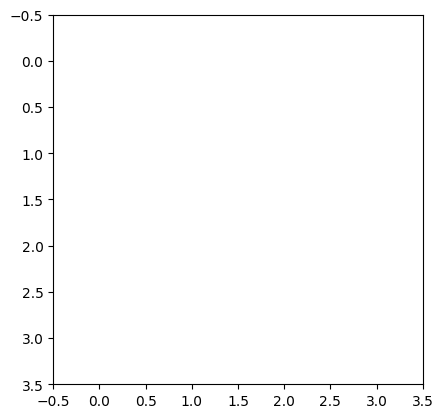

In [7]:
# get the image and the label
for img, label in dataset_example.take(1):
    img_example = img[0]
    label_example = label[0]
    break

# get the coordinates of the bottom right corner of the pokemon
x = 60
y = 60
w = 50
h = 50

# Slice the tensor to get the pixel values within the background area
img_white_area = img_example[y : y + h, x : x + w, :]

plt.imshow(img_white_area)

In [8]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

Epoch 1/100


2024-04-18 17:59:17.187125: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-04-18 17:59:19.187346: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 309ms/step - loss: 1.2801
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - loss: 0.8942
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - loss: 0.8905
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.8438

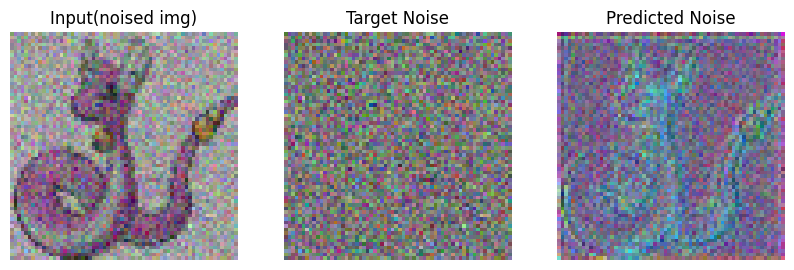

MSE area:  tf.Tensor(0.024651654, shape=(), dtype=float32)
MSE:  tf.Tensor(0.57522154, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


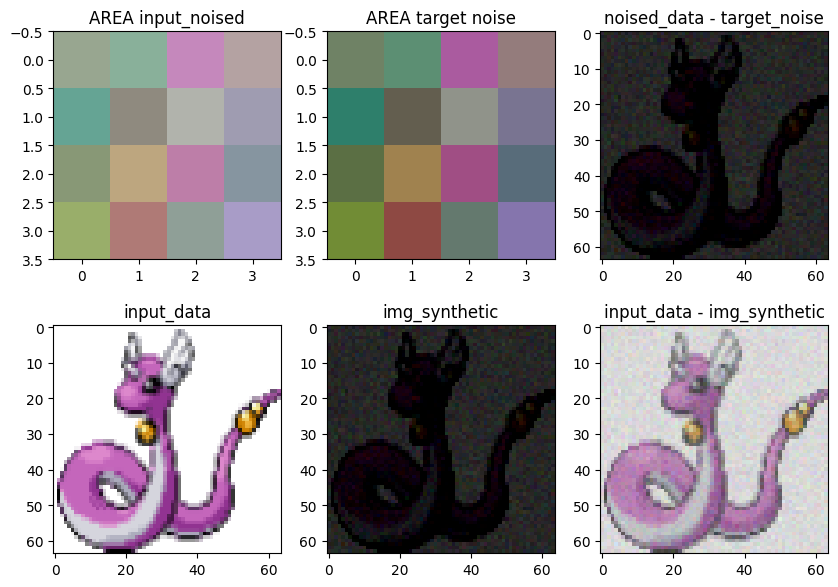

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - loss: 0.7501
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.7092
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - loss: 0.6050
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.5535
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.4642

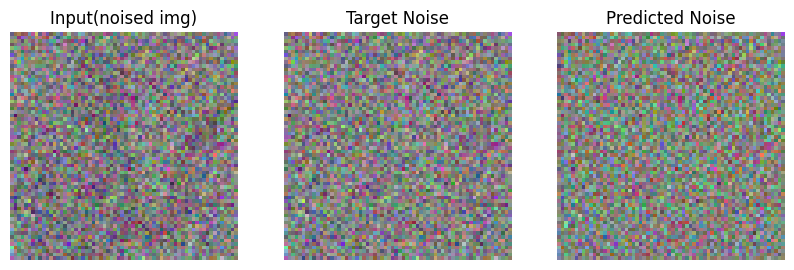

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(1.0362081e-15, shape=(), dtype=float32)
MSE:  tf.Tensor(0.7489545, shape=(), dtype=float32)


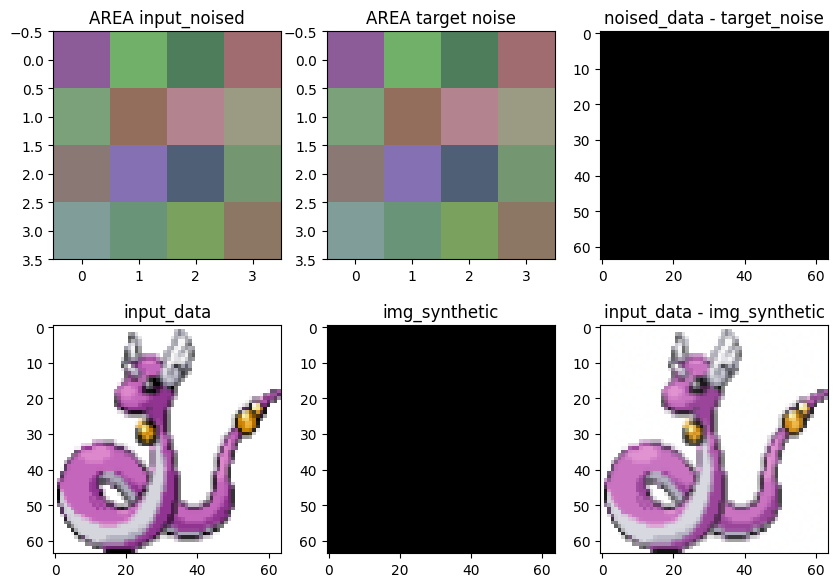

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - loss: 0.4126
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.4442
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.3382
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.3168
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.4108

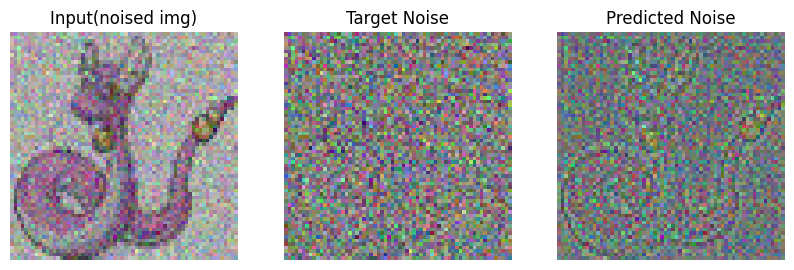

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.027587742, shape=(), dtype=float32)
MSE:  tf.Tensor(0.5494552, shape=(), dtype=float32)


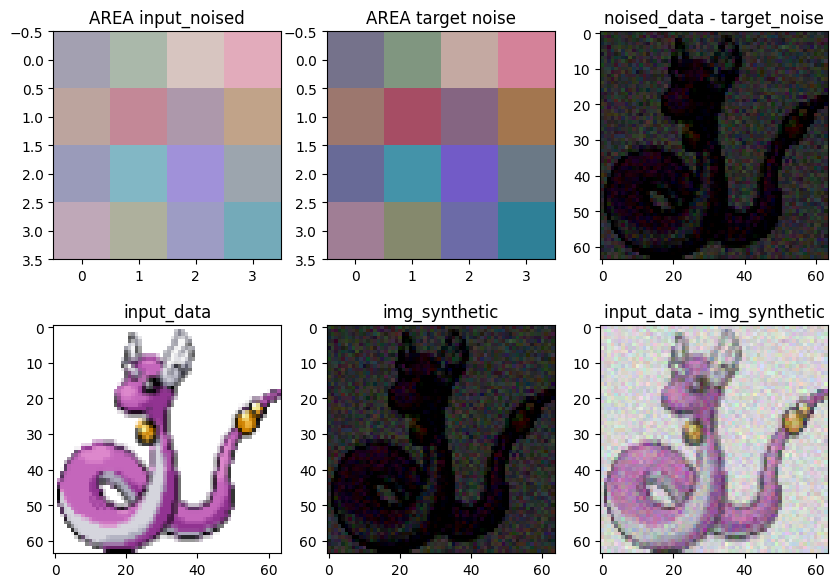

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - loss: 0.3651
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.2178
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.2046
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.2062
Epoch 16/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.1932

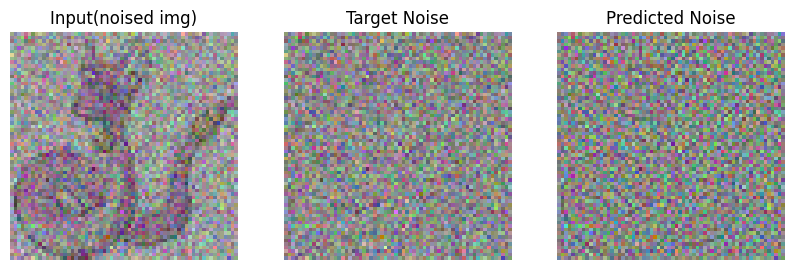

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.00399839, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6800967, shape=(), dtype=float32)


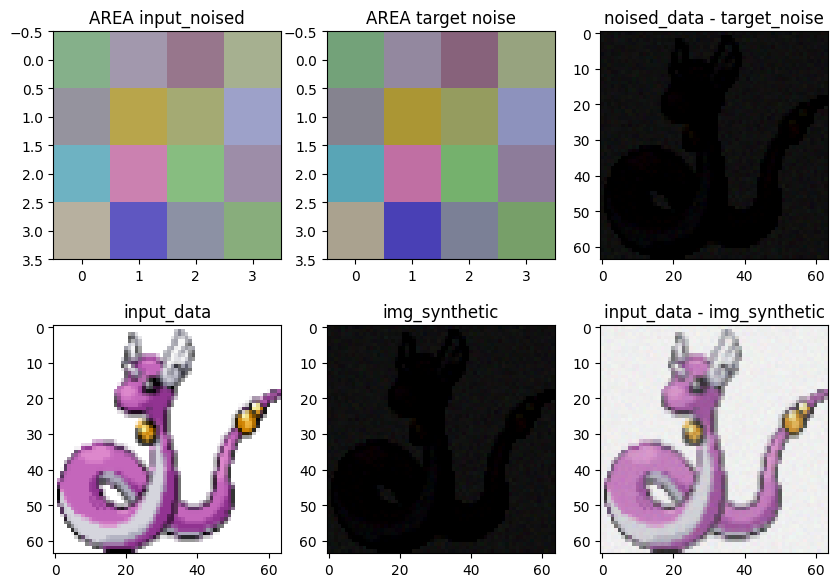

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 365ms/step - loss: 0.1717
Epoch 17/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step - loss: 0.1237
Epoch 18/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.1077
Epoch 19/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.2149
Epoch 20/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.2304

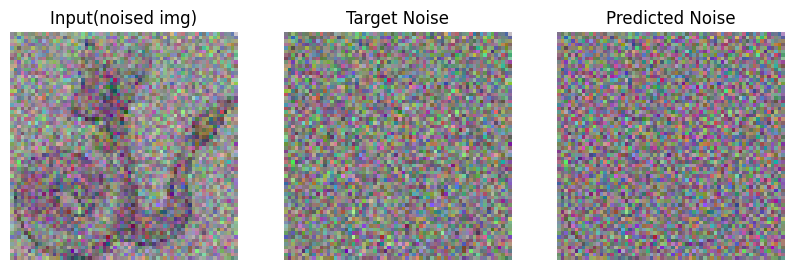

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.005164904, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6709645, shape=(), dtype=float32)


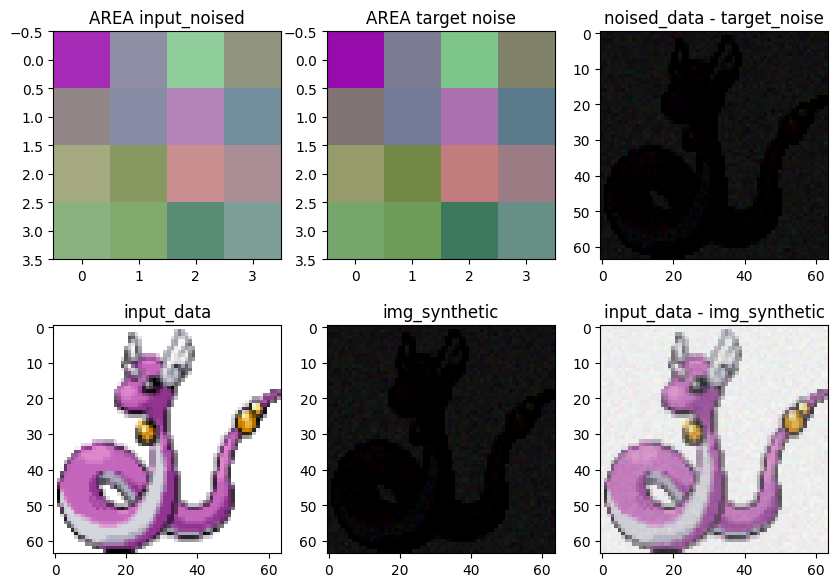

Epoch 20: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.28it/s]


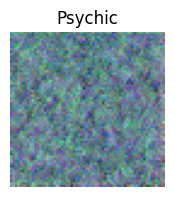

8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - loss: 0.2048  
Epoch 21/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.2607
Epoch 22/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - loss: 0.2194
Epoch 23/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.1364
Epoch 24/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.4140

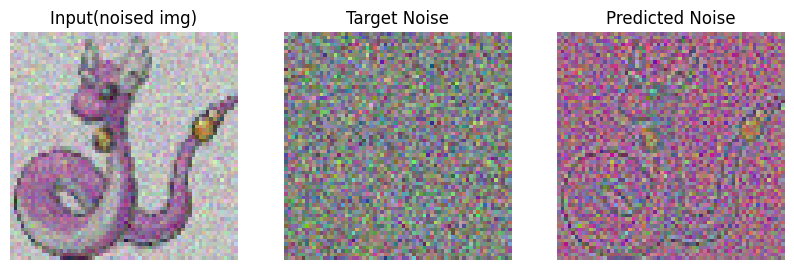

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.066656046, shape=(), dtype=float32)
MSE:  tf.Tensor(0.46617004, shape=(), dtype=float32)


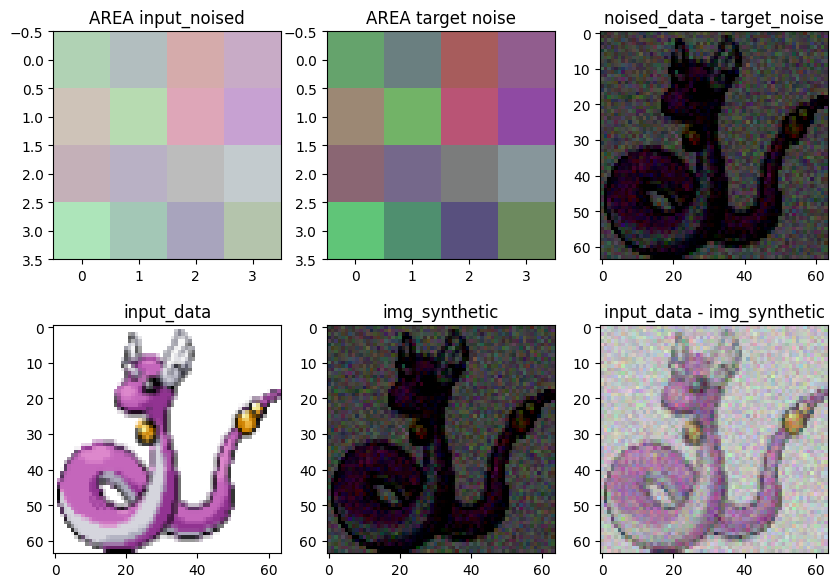

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - loss: 0.3680
Epoch 25/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.1597
Epoch 26/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.1505
Epoch 27/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - loss: 0.1083
Epoch 28/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0845

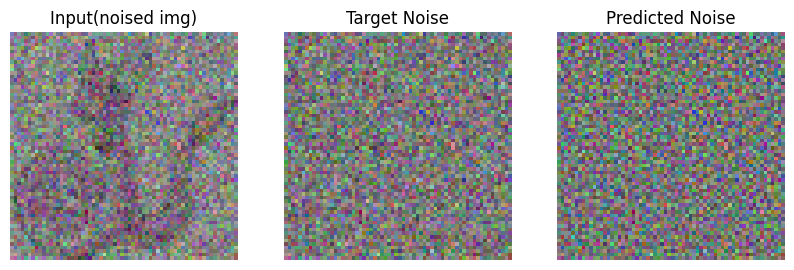

MSE area:  tf.Tensor(0.0027017735, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6850688, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


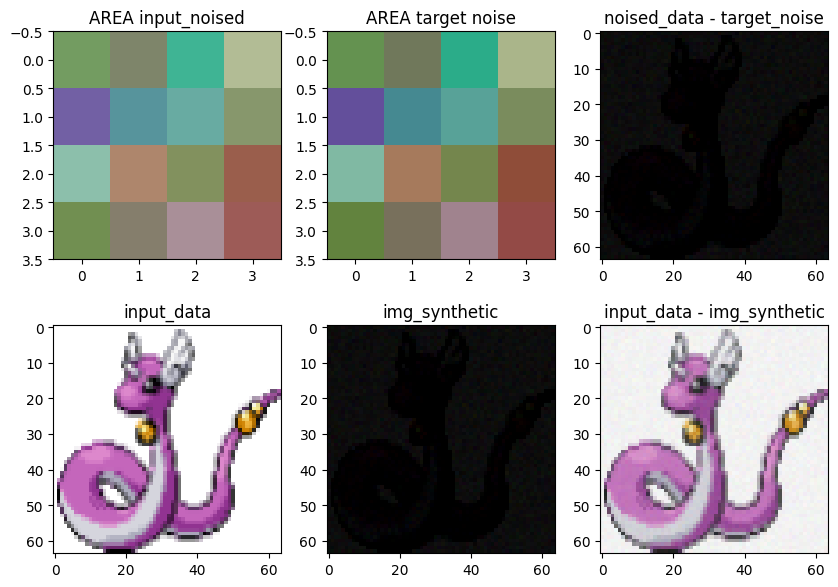

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step - loss: 0.0751
Epoch 29/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - loss: 0.0915
Epoch 30/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - loss: 0.0724
Epoch 31/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step - loss: 0.2308
Epoch 32/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.0957

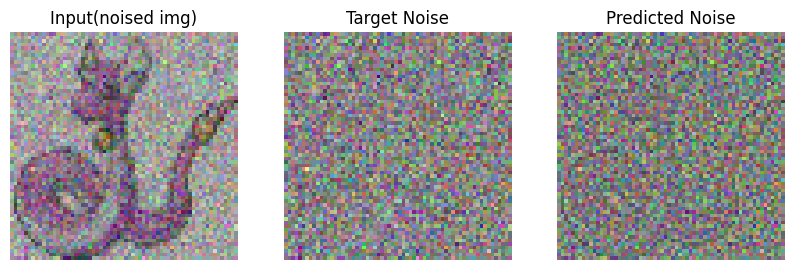

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.011938316, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6346925, shape=(), dtype=float32)


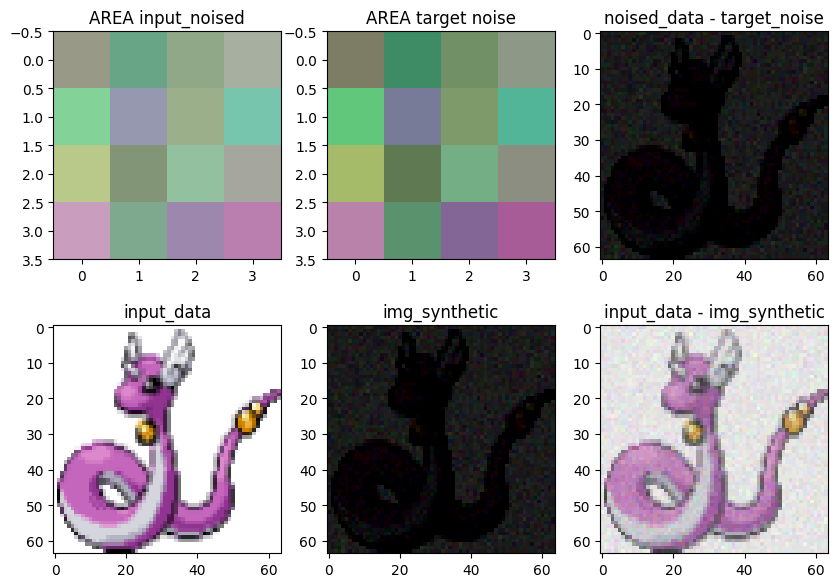

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 395ms/step - loss: 0.0851
Epoch 33/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - loss: 0.1377
Epoch 34/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.1022
Epoch 35/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.1101
Epoch 36/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.1605

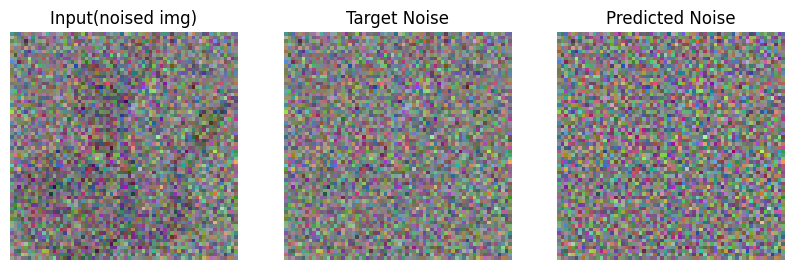

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(1.1584779e-06, shape=(), dtype=float32)
MSE:  tf.Tensor(0.755827, shape=(), dtype=float32)


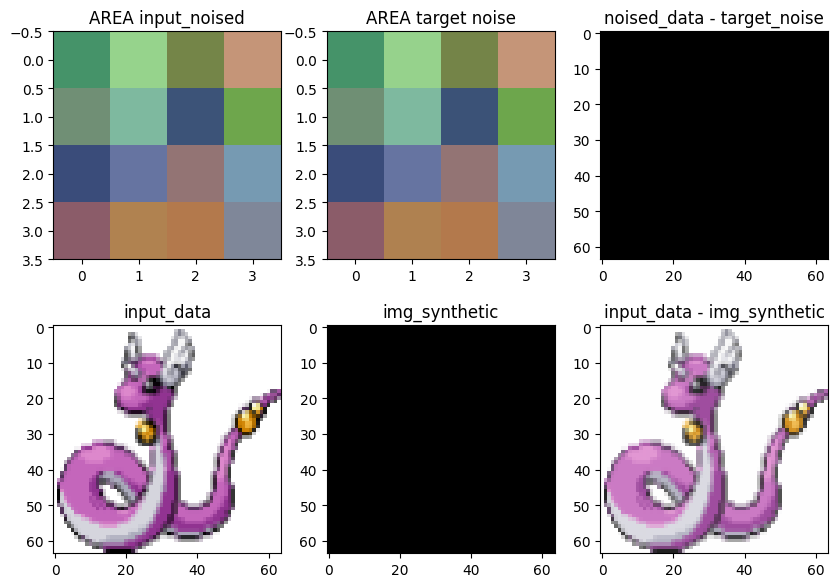

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - loss: 0.1427
Epoch 37/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.1549
Epoch 38/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.0746
Epoch 39/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.1584
Epoch 40/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.1201

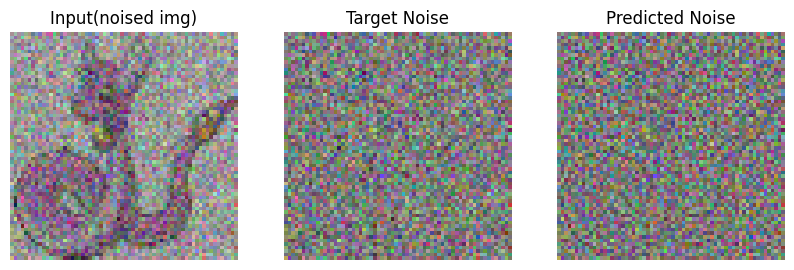

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.012154456, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6149926, shape=(), dtype=float32)


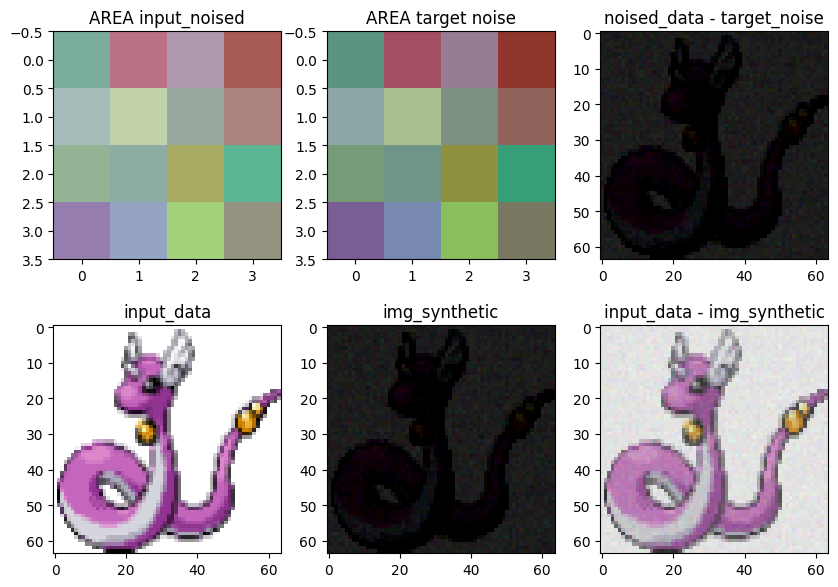

Epoch 40: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.26it/s]


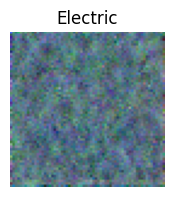

8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - loss: 0.1068  
Epoch 41/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - loss: 0.1786
Epoch 42/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.0672
Epoch 43/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.1289
Epoch 44/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.1310

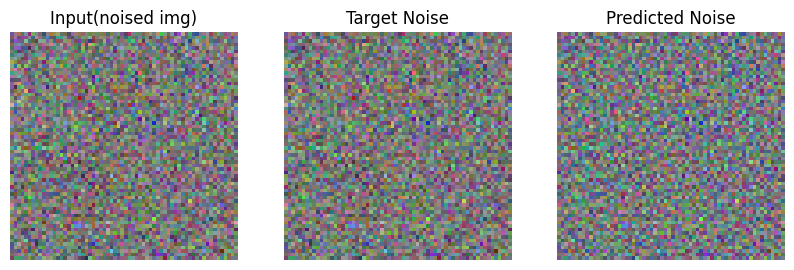

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(2.8846289e-05, shape=(), dtype=float32)
MSE:  tf.Tensor(0.7306164, shape=(), dtype=float32)


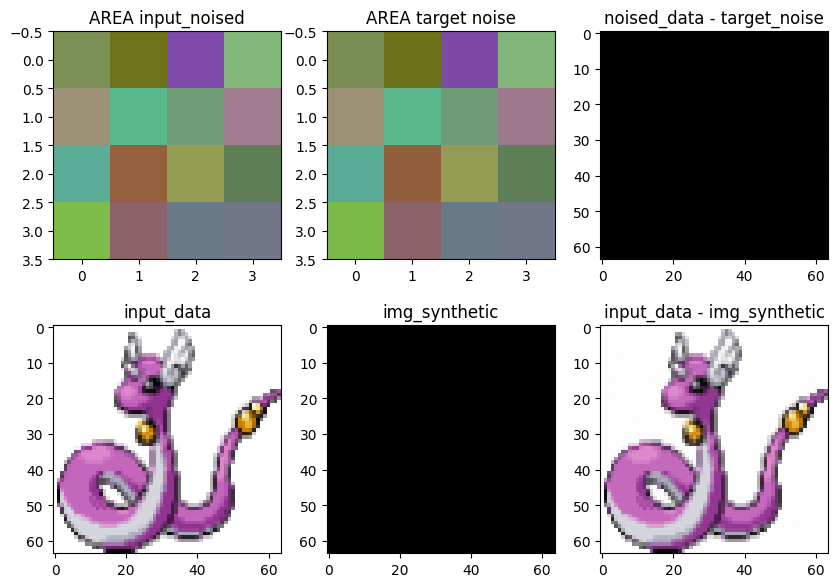

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - loss: 0.1164
Epoch 45/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.1634
Epoch 46/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - loss: 0.1175
Epoch 47/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.2207
Epoch 48/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.0700

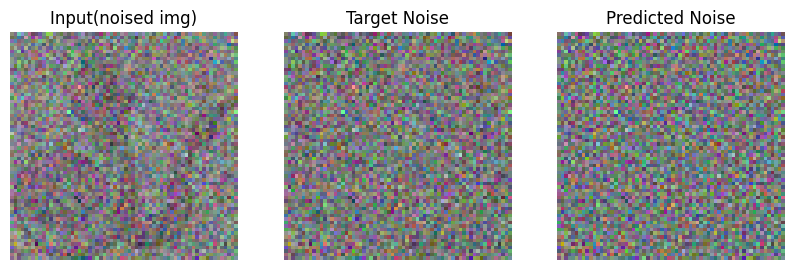

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.0017631863, shape=(), dtype=float32)
MSE:  tf.Tensor(0.691391, shape=(), dtype=float32)


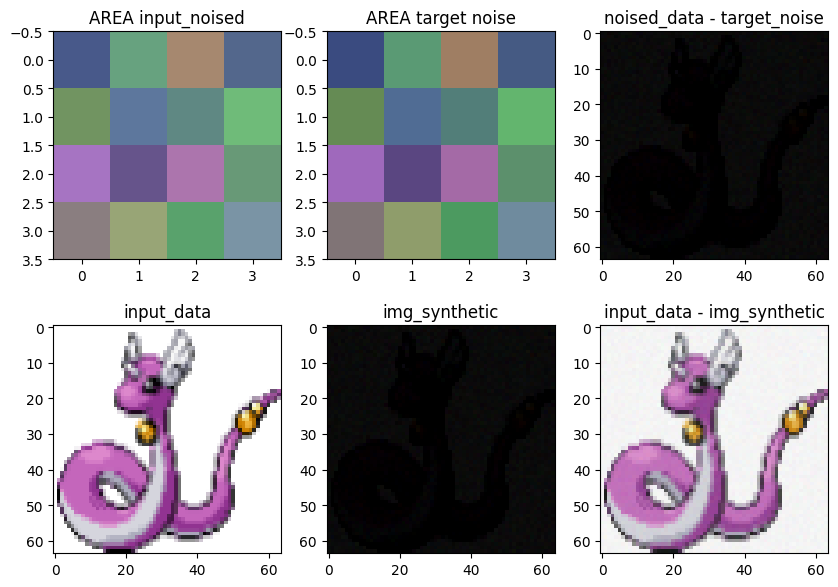

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - loss: 0.0622
Epoch 49/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.2386
Epoch 50/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.1451
Epoch 51/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - loss: 0.0975
Epoch 52/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.3228

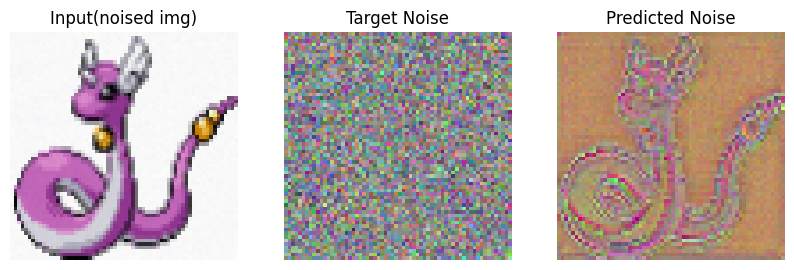

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.19139577, shape=(), dtype=float32)
MSE:  tf.Tensor(0.32388982, shape=(), dtype=float32)


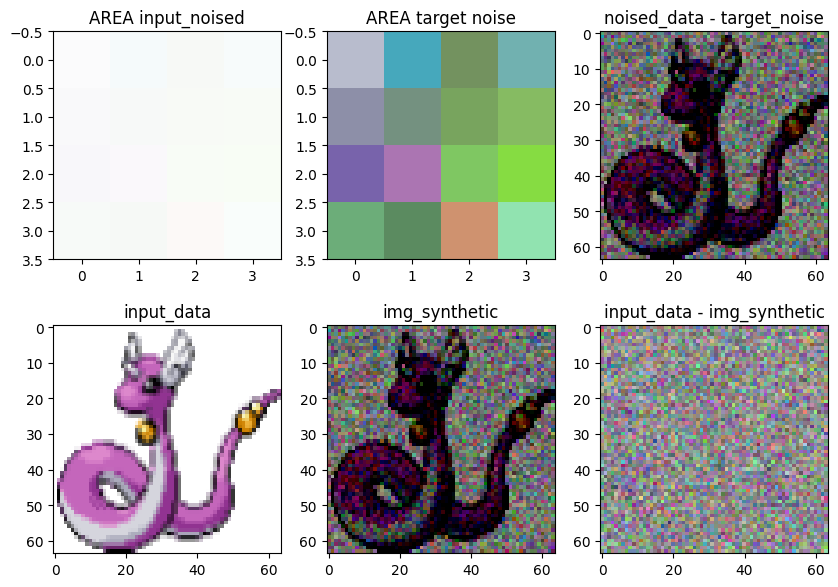

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - loss: 0.2869
Epoch 53/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - loss: 0.0954
Epoch 54/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - loss: 0.3215
Epoch 55/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.2828
Epoch 56/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.1873

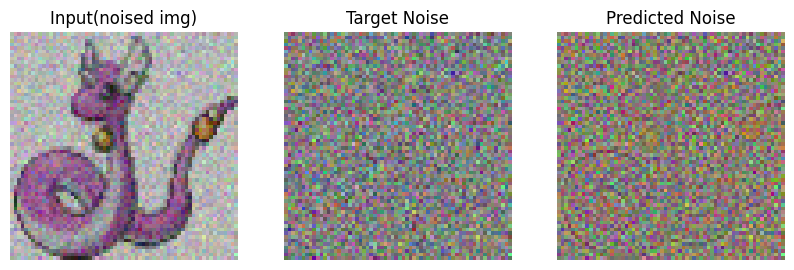

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.044293966, shape=(), dtype=float32)
MSE:  tf.Tensor(0.5203899, shape=(), dtype=float32)


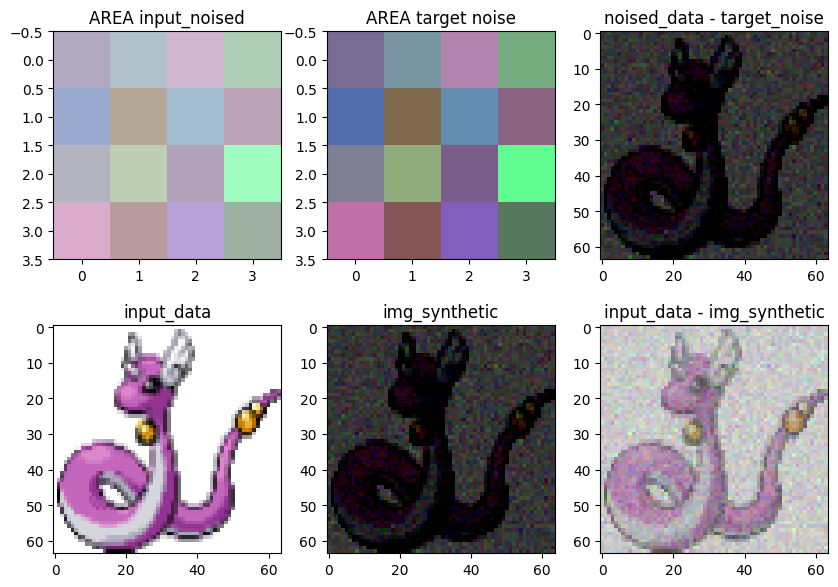

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - loss: 0.1665
Epoch 57/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 0.1319
Epoch 58/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - loss: 0.0992
Epoch 59/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - loss: 0.2396
Epoch 60/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.3616

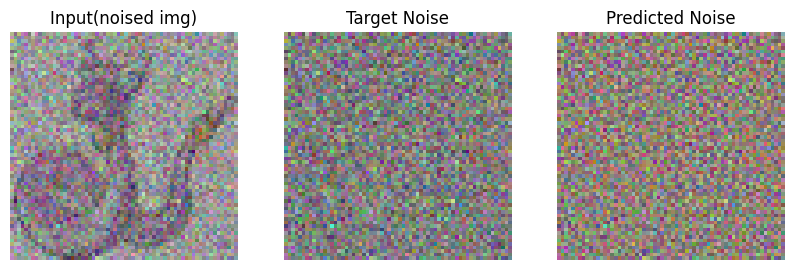

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.011302861, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6134724, shape=(), dtype=float32)


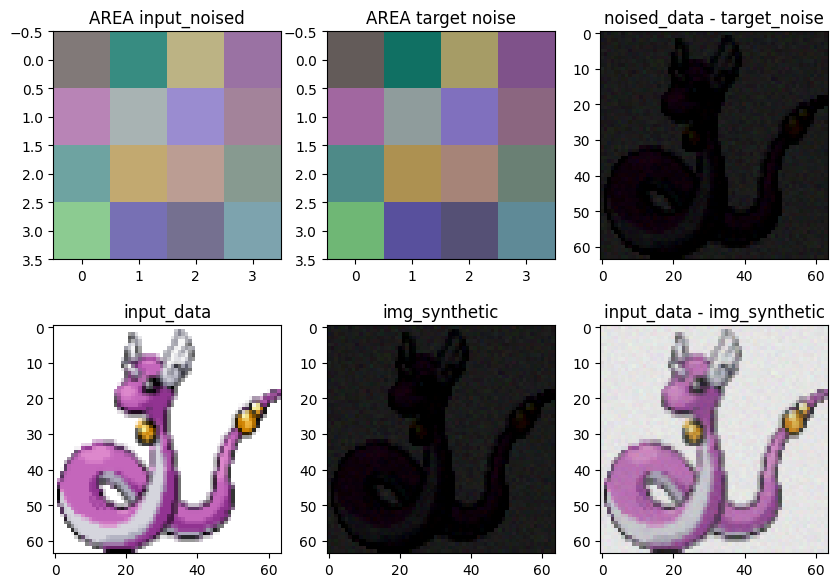

Epoch 60: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.54it/s]


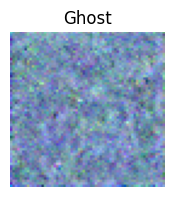

8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - loss: 0.3215  
Epoch 61/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - loss: 0.1194
Epoch 62/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - loss: 0.1192
Epoch 63/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.0699
Epoch 64/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0777

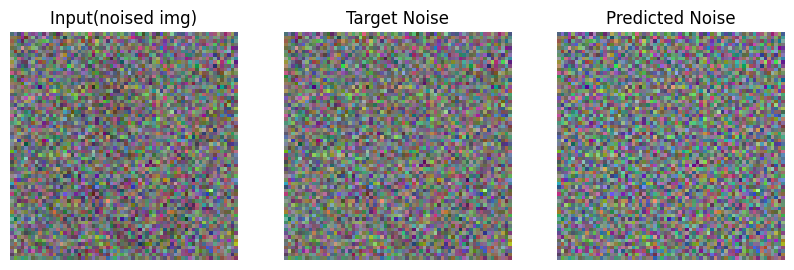

MSE area:  tf.Tensor(1.1657342e-15, shape=(), dtype=float32)
MSE:  tf.Tensor(0.74629706, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


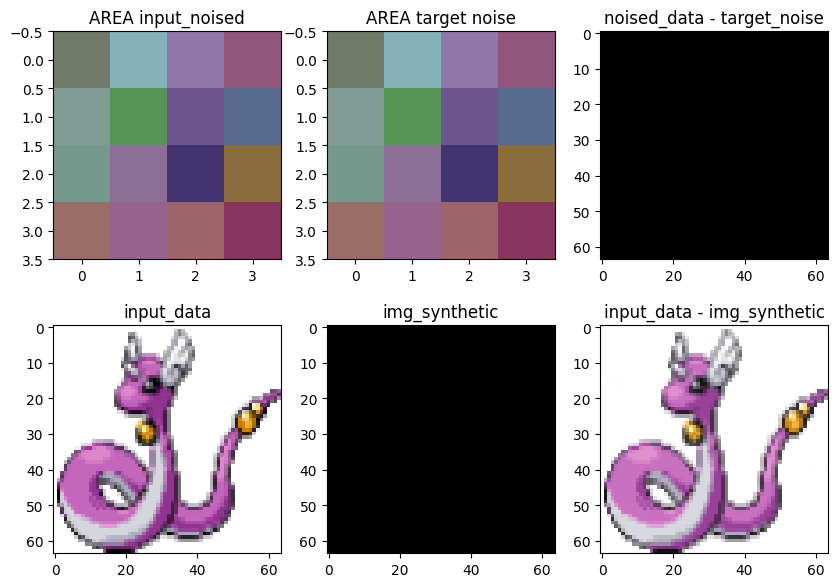

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - loss: 0.0690
Epoch 65/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.0688
Epoch 66/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 0.0552
Epoch 67/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 0.0786
Epoch 68/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.0641

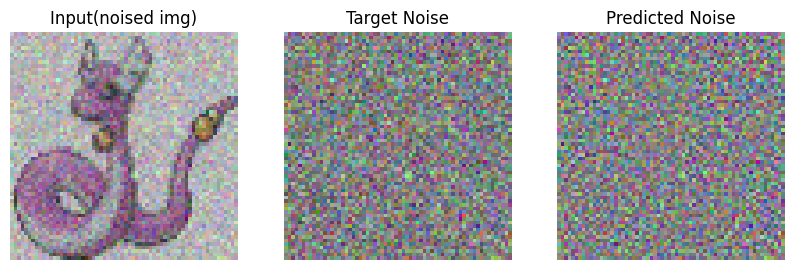

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.0438489, shape=(), dtype=float32)
MSE:  tf.Tensor(0.5070585, shape=(), dtype=float32)


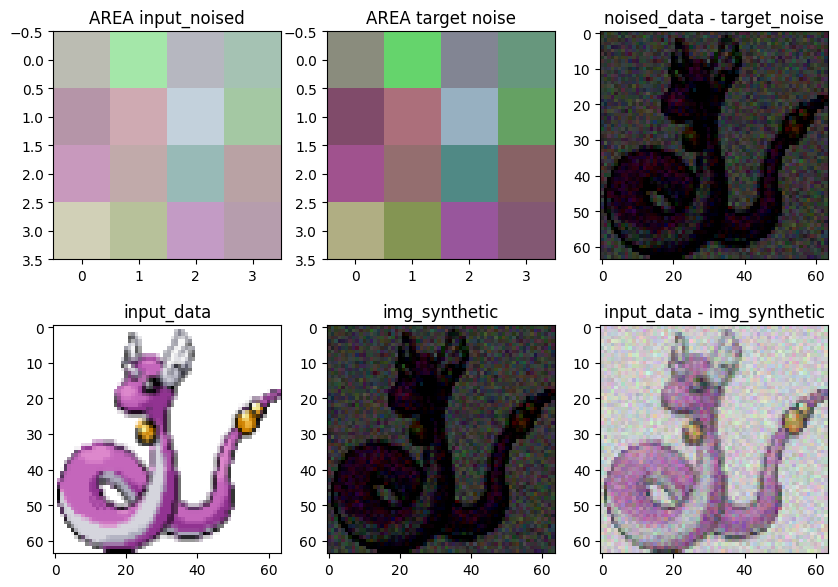

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 379ms/step - loss: 0.0569
Epoch 69/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.0701
Epoch 70/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - loss: 0.0600
Epoch 71/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.1210
Epoch 72/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.2020

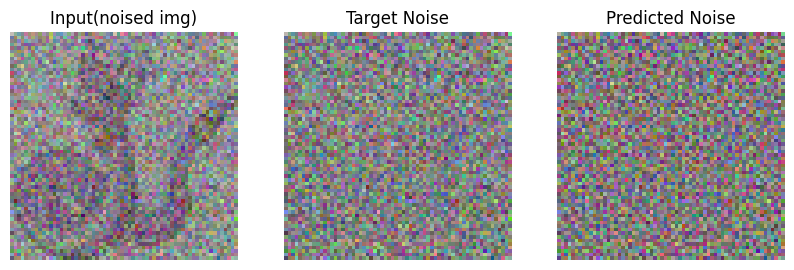

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.0031249046, shape=(), dtype=float32)
MSE:  tf.Tensor(0.6824476, shape=(), dtype=float32)


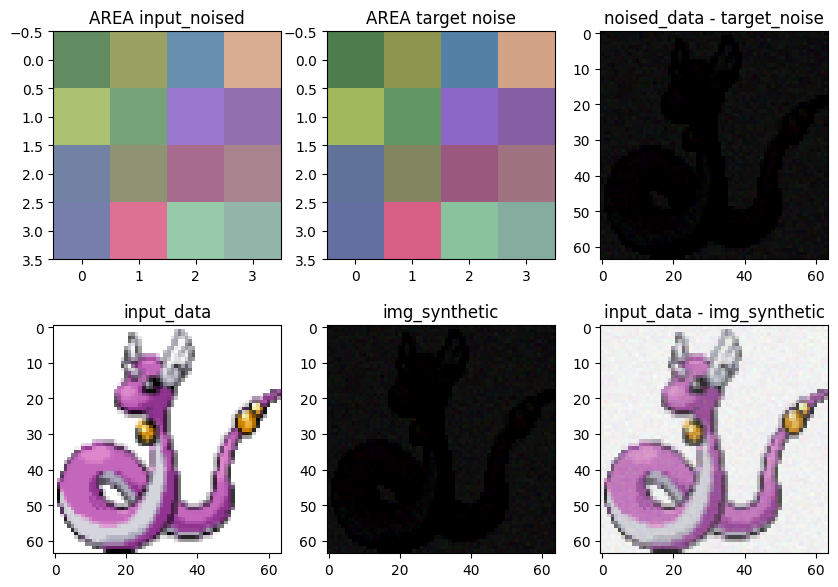

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 388ms/step - loss: 0.1796
Epoch 73/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.0909
Epoch 74/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.0775
Epoch 75/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 0.0610
Epoch 76/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.1108

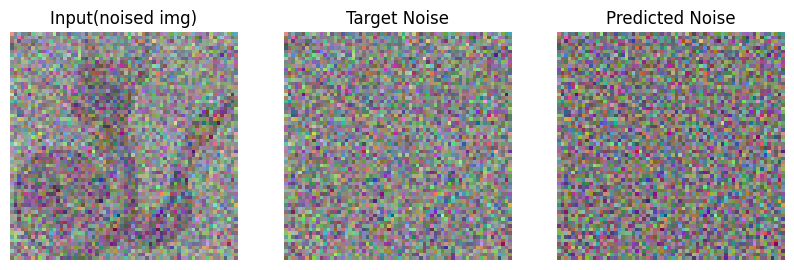

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.0018074446, shape=(), dtype=float32)
MSE:  tf.Tensor(0.7033096, shape=(), dtype=float32)


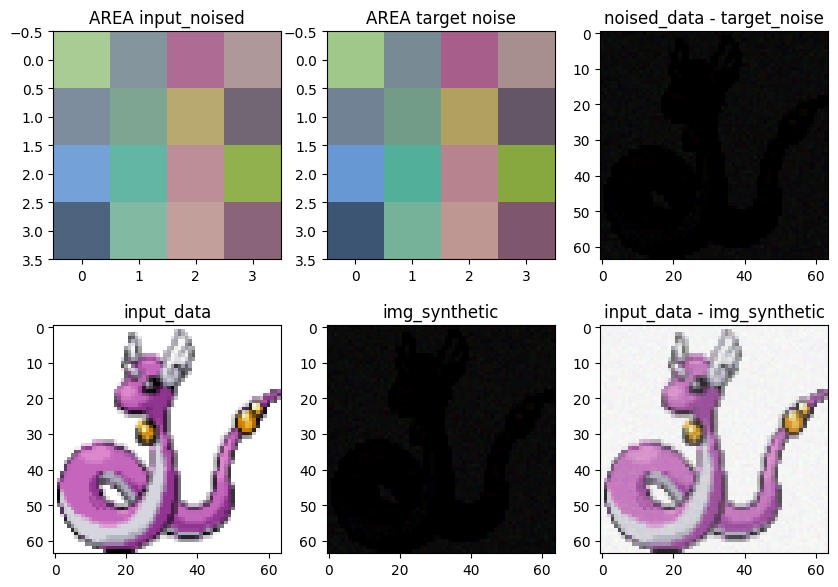

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - loss: 0.0985
Epoch 77/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - loss: 0.1603
Epoch 78/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.1133
Epoch 79/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - loss: 0.0556
Epoch 80/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.0642

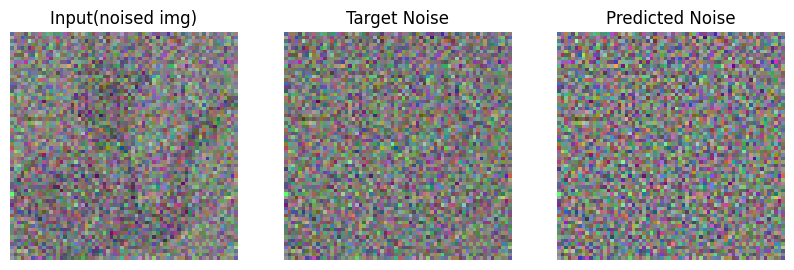

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE area:  tf.Tensor(0.0009862185, shape=(), dtype=float32)
MSE:  tf.Tensor(0.7056938, shape=(), dtype=float32)


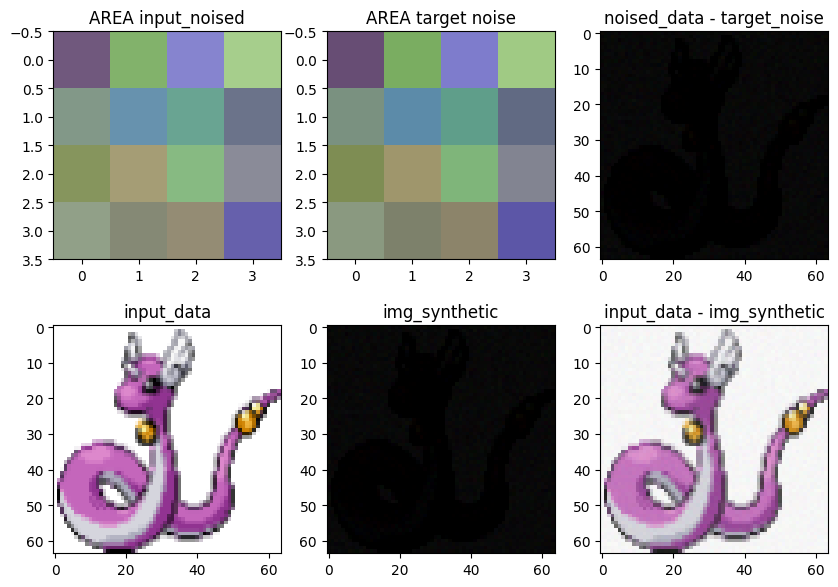

Epoch 80: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.31it/s]


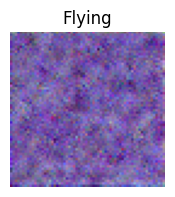

8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - loss: 0.0571  
Epoch 81/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - loss: 0.1404
Epoch 82/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.0464
Epoch 83/100
1/8 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - loss: 0.5117

In [9]:
tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(
    dataset_example,
    epochs=EPOCHS,
    callbacks=[PlottingCallback(model, 4), DiffusionCallback(model, 20)],
)
# model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 10)])

Generating sample 1/1


Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.65it/s]


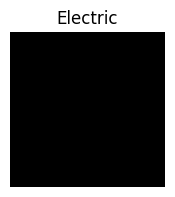

In [ ]:
model.plot_samples(1, "Dragon")

In [ ]:
model.plot_samples(4)

Generating sample 1/4


Sampling sprite: 100%|██████████| 999/999 [00:42<00:00, 23.32it/s]


Generating sample 2/4


Sampling sprite:  71%|███████   | 705/999 [00:30<00:12, 22.92it/s]

In [ ]:
# df = preprocess.load_csv("../../dataset/pokedex.csv")
# data_path = preprocess.load_paths_from_file("../../dataset/image_paths.json")
# data_dict = preprocess.dataset_dict(data_path, df)
# dataset = preprocess.create_dataset(data_dict, df, size=IMG_SIZE, batch_size=BATCH_SIZE)
# label_mappping = preprocess.create_label_mapping(df)

# def generate_em(num_classes: int = NUM_CLASSES) -> np.ndarray:
#     """Generates a random embedding (label)

#     :param num_classes: The number of classes
#     """

#     em = np.zeros(num_classes)
#     em[np.where(label_example[0] == 1)[0][0]] = 1
#     return em


# generate_em()
# plotter.onehot_to_string(generate_em(), label_mappping)